In [1]:
import ipsuite as ips

2023-08-03 10:29:58,389 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


DFT based on https://www.sciencedirect.com/science/article/pii/S1386142521004455#b0030

In [2]:
thermostat = ips.calculators.LangevinThermostat(
    temperature=298.15, friction=0.01, time_step=0.5
)

uncertainty_check = ips.analysis.ThresholdCheck(
    value="energy_uncertainty", max_value=2.0, larger_only=True
)

mapping = ips.geometry.BarycenterMapping(data=None)
temperature_oszillator = ips.calculators.TemperatureOscillatingRampModifier(
    end_temperature=450,  # boiling around 460
    start_temperature=270,  # melting around 290
    num_oscillations=10,
    temperature_amplitude=150,
)

box_oszillator = ips.calculators.BoxOscillatingRampModifier(
    cell_amplitude=1,
    num_oscillations=3,
)

models = []

with ips.Project(automatic_node_names=True) as project:
    mol = ips.configuration_generation.SmilesToAtoms(smiles="CS(=O)C")

    # Create a box of atoms.
    packmol = ips.configuration_generation.Packmol(
        data=[mol.atoms], count=[38], density=1095.2
    )

    # Define the CP2K calculations
    cp2k = ips.calculators.CP2KSinglePoint(
        data=packmol.atoms,
        cp2k_files=["BASIS_MOLOPT", "GTH_POTENTIALS", "dftd3.dat"],
        cp2k_shell="cp2k_shell.ssmp",
    )

    geopt = ips.calculators.ASEGeoOpt(
        model=cp2k,
        data=packmol.atoms,
        optimizer="BFGS",
        run_kwargs={"fmax": 0.5},
    )

    test_selection = ips.configuration_selection.RandomSelection(
        data=geopt.atoms, n_configurations=20
    )

    train_data = test_selection.excluded_atoms
    test_data = test_selection.atoms

    for cycle in range(6):
        with project.group(name=f"AL_{cycle}") as group:
            # Define the ML model
            model1 = ips.models.Apax(
                data=train_data,
                validation_data=test_data,
                config="config/apax_1.yaml" if cycle < 5 else "config/apax_3.yaml",
            )
            model2 = ips.models.Apax(
                data=train_data,
                validation_data=test_data,
                config="config/apax_2.yaml" if cycle < 5 else "config/apax_4.yaml",
            )

            ensemble_model = ips.models.EnsembleModel(models=[model1, model2])

            models.append(ensemble_model)

            md = ips.calculators.ASEMD(
                data=geopt.atoms,
                data_id=-1,
                model=ensemble_model,
                thermostat=thermostat,
                checker_list=[uncertainty_check],
                steps=50000,
                sampling_rate=1,
            )

            train_data_selection = ips.configuration_selection.ThresholdSelection(
                data=md, n_configurations=10, min_distance=10
            )

            test_data_selection = ips.configuration_selection.RandomSelection(
                data=md,
                n_configurations=5,
                exclude_configurations=train_data_selection.selected_configurations,
            )

            # evaluate the model
            prediction = ips.analysis.Prediction(model=ensemble_model, data=test_data)
            metrics = ips.analysis.PredictionMetrics(data=prediction)
            force_decomposition = ips.analysis.ForceDecomposition(data=prediction)

            train_data += ips.calculators.CP2KSinglePoint(
                data=train_data_selection,
                cp2k_files=["BASIS_MOLOPT", "GTH_POTENTIALS", "dftd3.dat"],
                cp2k_shell="cp2k_shell.ssmp",
                wfn_restart_node=cp2k,
            ).atoms

            test_data += ips.calculators.CP2KSinglePoint(
                data=test_data_selection,
                cp2k_files=["BASIS_MOLOPT", "GTH_POTENTIALS", "dftd3.dat"],
                cp2k_shell="cp2k_shell.ssmp",
                wfn_restart_node=cp2k,
            ).atoms

            md_forces_uncertainty = ips.analysis.ForcesUncertaintyHistogram(
                data=md.atoms
            )
            md_energy_uncertainty = ips.analysis.EnergyUncertaintyHistogram(
                data=md.atoms
            )

            volume_scan = ips.analysis.BoxScale(
                data=geopt.atoms,
                mapping=mapping,
                model=ensemble_model,
                start=0.9,
                data_id=-1,
            )

    with project.group(name="bootstrap_0") as group:
        bootstrap_train_data = (
            ips.bootstrap.RotateMolecules(
                data=geopt.atoms,
                data_id=-1,
                n_configurations=10,
                maximum=10 * 3.1415 / 180,  # deg max rotation
                include_original=False,
                seed=1,
            ).atoms
            + ips.bootstrap.TranslateMolecules(
                data=geopt.atoms,
                data_id=-1,
                n_configurations=10,
                maximum=0.2,  # Ang max molecular displacement
                include_original=False,
                seed=1,
            ).atoms
        )

        bootstrap_test_data = (
            ips.bootstrap.RotateMolecules(
                data=geopt.atoms,
                data_id=-1,
                n_configurations=5,
                maximum=10 * 3.1415 / 180,  # deg max rotation
                include_original=False,
                seed=2,
                name="RotateMolecules_test",
            ).atoms
            + ips.bootstrap.TranslateMolecules(
                data=geopt.atoms,
                data_id=-1,
                n_configurations=5,
                maximum=0.2,  # Ang max molecular displacement
                include_original=False,
                seed=2,
                name="TranslateMolecules_test",
            ).atoms
        )

        train_data += ips.calculators.CP2KSinglePoint(
            data=bootstrap_train_data,
            cp2k_files=["BASIS_MOLOPT", "GTH_POTENTIALS", "dftd3.dat"],
            cp2k_shell="cp2k_shell.ssmp",
            wfn_restart_node=cp2k,
        ).atoms

        test_data += ips.calculators.CP2KSinglePoint(
            data=bootstrap_test_data,
            cp2k_files=["BASIS_MOLOPT", "GTH_POTENTIALS", "dftd3.dat"],
            cp2k_shell="cp2k_shell.ssmp",
            wfn_restart_node=cp2k,
        ).atoms

        model1 = ips.models.Apax(
            data=train_data,
            validation_data=test_data,
            config="config/apax_3.yaml",
        )
        model2 = ips.models.Apax(
            data=train_data,
            validation_data=test_data,
            config="config/apax_4.yaml",
        )

        ensemble_model = ips.models.EnsembleModel(models=[model1, model2])

        models.append(ensemble_model)

        # md = ips.calculators.ASEMD(
        #         data=geopt.atoms,
        #         data_id=-1,
        #         model=ensemble_model,
        #         thermostat=thermostat,
        #         checker_list=[uncertainty_check],
        #         steps=50000,
        #         sampling_rate=100,
        #     )

        # evaluate the model
        prediction = ips.analysis.Prediction(model=ensemble_model, data=test_data)
        metrics = ips.analysis.PredictionMetrics(data=prediction)

        force_decomposition = ips.analysis.ForceDecomposition(data=prediction)
        volume_scan = ips.analysis.BoxScale(
            data=geopt.atoms,
            mapping=mapping,
            model=ensemble_model,
            start=0.9,
            data_id=-1,
        )

    with project.group(name="bootstrap_1") as group:
        md = ips.calculators.ASEMD(
            data=geopt.atoms,
            data_id=-1,
            model=ensemble_model,
            thermostat=thermostat,
            checker_list=[uncertainty_check],
            modifier=[temperature_oszillator, box_oszillator],
            steps=10000,
            sampling_rate=100,
        )

        train_data_selection_1 = ips.configuration_selection.ThresholdSelection(
            data=md, n_configurations=20, min_distance=10
        )
        train_data_selection_2 = ips.configuration_selection.RandomSelection(
            data=train_data_selection_1.excluded_atoms, n_configurations=80
        )
        test_data_selection = ips.configuration_selection.RandomSelection(
            data=train_data_selection_2.excluded_atoms, n_configurations=20
        )

        train_data += ips.calculators.CP2KSinglePoint(
            data=train_data_selection_1.atoms + train_data_selection_2.atoms,
            cp2k_files=["BASIS_MOLOPT", "GTH_POTENTIALS", "dftd3.dat"],
            cp2k_shell="cp2k_shell.ssmp",
            wfn_restart_node=cp2k,
        ).atoms

        test_data += ips.calculators.CP2KSinglePoint(
            data=test_data_selection.atoms,
            cp2k_files=["BASIS_MOLOPT", "GTH_POTENTIALS", "dftd3.dat"],
            cp2k_shell="cp2k_shell.ssmp",
            wfn_restart_node=cp2k,
        ).atoms

    with project.group(name="volume_scan") as group:
        md = ips.calculators.ASEMD(
            data=geopt.atoms,
            data_id=-1,
            model=ensemble_model,
            thermostat=thermostat,
            checker_list=[uncertainty_check],
            steps=250,
            sampling_rate=10,
        )

        volume_scan = ips.analysis.BoxScale(
            data=md.atoms,
            mapping=mapping,
            model=ensemble_model,
            start=0.9,
            stop=1.7,
            num=50,
            data_id=-1,
        )

        vs_cp2k = ips.calculators.CP2KSinglePoint(
            data=volume_scan.atoms,
            cp2k_files=["BASIS_MOLOPT", "GTH_POTENTIALS", "dftd3.dat"],
            cp2k_shell="cp2k_shell.ssmp",
            wfn_restart_node=cp2k,
        )

    with project.group(name="final") as final:
        model = ips.models.Apax(
            data=train_data,
            validation_data=test_data,
            config="config/apax_final.yaml",
        )

        models.append(model)

        # evaluate the model
        prediction = ips.analysis.Prediction(model=model, data=test_data)
        metrics = ips.analysis.PredictionMetrics(data=prediction)

        force_decomposition = ips.analysis.ForceDecomposition(data=prediction)
        volume_scan = ips.analysis.BoxScale(
            data=geopt.atoms, mapping=mapping, model=model, start=0.9, data_id=-1
        )
    
    with project.group("ALEvaluation") as ALEvaluation:
        for model in models:
            prediction = ips.analysis.Prediction(model=model, data=test_data_selection.atoms)
            metrics = ips.analysis.PredictionMetrics(data=prediction)
            # force_decomposition = ips.analysis.ForceDecomposition(data=prediction)
            # volume_scan = ips.analysis.BoxScale(
            #     data=geopt.atoms, mapping=mapping, model=model, start=0.9, data_id=-1
            # )



project.build(nodes=[ALEvaluation])

Running DVC command: 'stage add --name ALEvaluation_Prediction --force ...'
 Running DVC command: 'stage add --name ALEvaluation_PredictionMetrics --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_Prediction_1 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_PredictionMetrics_1 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_Prediction_2 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_PredictionMetrics_2 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_Prediction_3 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_PredictionMetrics_3 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_Prediction_4 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_PredictionMetrics_4 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_Prediction_5 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_PredictionMetrics_5 --force ...'


  

 Running DVC command: 'stage add --name ALEvaluation_Prediction_6 --force ...'
 Running DVC command: 'stage add --name ALEvaluation_PredictionMetrics_6 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_Prediction_7 --force ...'


 

 Running DVC command: 'stage add --name ALEvaluation_PredictionMetrics_7 --force ...'


  

 

In [7]:
import zntrack
import matplotlib.pyplot as plt
import numpy as np

In [4]:
dft_vs = zntrack.from_rev("volume_scan_CP2KSinglePoint_1")
mlp_vs = zntrack.from_rev("volume_scan_BoxScale")

array([0.9       , 0.91632653, 0.93265306, 0.94897959, 0.96530612,
       0.98163265, 0.99795918, 1.01428571, 1.03061224, 1.04693878,
       1.06326531, 1.07959184, 1.09591837, 1.1122449 , 1.12857143,
       1.14489796, 1.16122449, 1.17755102, 1.19387755, 1.21020408,
       1.22653061, 1.24285714, 1.25918367, 1.2755102 , 1.29183673,
       1.30816327, 1.3244898 , 1.34081633, 1.35714286, 1.37346939,
       1.38979592, 1.40612245, 1.42244898, 1.43877551, 1.45510204,
       1.47142857, 1.4877551 , 1.50408163, 1.52040816, 1.53673469,
       1.55306122, 1.56938776, 1.58571429, 1.60204082, 1.61836735,
       1.63469388, 1.65102041, 1.66734694, 1.68367347, 1.7       ])

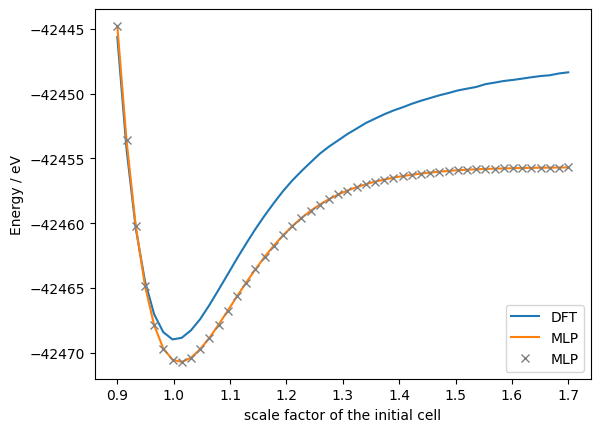

In [13]:
fig, ax = plt.subplots()
ax.plot(np.linspace(mlp_vs.start, mlp_vs.stop, mlp_vs.num), [x.get_potential_energy() for x in dft_vs.atoms], label='DFT')
ax.plot(np.linspace(mlp_vs.start, mlp_vs.stop, mlp_vs.num), [x.get_potential_energy() for x in mlp_vs.atoms], label='MLP')
ax.plot(np.linspace(mlp_vs.start, mlp_vs.stop, mlp_vs.num), [x.get_potential_energy() for x in mlp_vs.atoms], 'x', label='MLP', color="grey")

ax.set_ylabel('Energy / eV')
ax.set_xlabel('scale factor of the initial cell')
ax.legend()

In [6]:
import zntrack
import matplotlib.pyplot as plt

In [9]:
nodes = []
for idx in range(8):
    name = f"ALEvaluation_PredictionMetrics_{idx}" if idx != 0 else "ALEvaluation_PredictionMetrics"
    nodes.append(zntrack.from_rev(name))

Text(0.5, 1.0, 'forces')

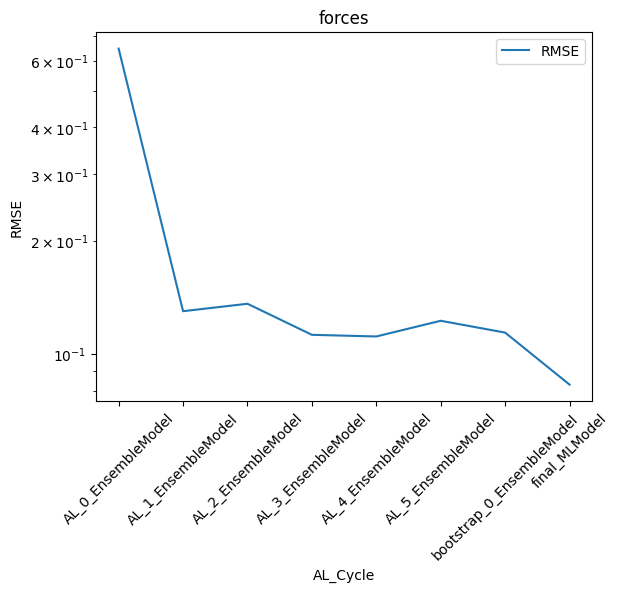

In [12]:
fig, ax = plt.subplots()
rmse = [x.forces["rmse"] for x in nodes]

ax.plot(rmse, label="RMSE")
ax.set_xlabel("AL_Cycle")
ax.set_ylabel("RMSE")
ax.set_yscale("log")
ax.set_xticks(range(len(nodes)))
ax.set_xticklabels([x.data.model.name for x in nodes])
ax.tick_params(axis='x', rotation=45)

ax.legend()
ax.set_title("forces")